
## Project 4: Churn Prediction Modelling 

---

My text here

In [67]:
import pandas as pd

data = r"/Users/meisan/Documents/GitHub/GA-DAT9-Projects1/R_Morgan_Project4_Files/telecom_data.csv"
df = pd.read_csv(data)
df.head()

,account_length,num_of_voice_mail_messages,total_day_calls,total_day_charge,total_eve_calls,total_eve_charge,total_night_calls,total_night_charge,total_intl_calls,total_intl_charge,number_customer_service_calls,international_plan_n,voice_mail_plan_n,area_code_408,area_code_415,area_code_510,churn_n
0,128,25,110,45.07,99,16.78,91,11.01,3,2.70,1,0,1,0,1,0,0
1,107,26,123,27.47,103,16.62,103,11.45,3,3.70,1,0,1,0,1,0,0
2,137,0,114,41.38,110,10.30,104,7.32,5,3.29,0,0,0,0,1,0,0
3,84,0,71,50.90,88,5.26,89,8.86,7,1.78,2,1,0,1,0,0,0
4,75,0,113,28.34,122,12.61,121,8.41,3,2.73,3,1,0,0,1,0,0


In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

% matplotlib inline

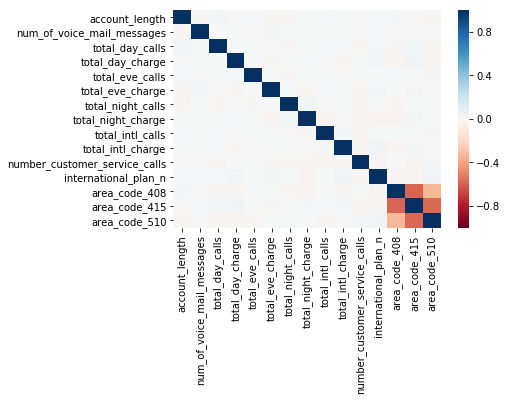

In [69]:
#establish list of features saved from EDA, print heatmap to check for colinearity between features
feature_names = ['account_length','num_of_voice_mail_messages','total_day_calls','total_day_charge',
                 'total_eve_calls','total_eve_charge','total_night_calls','total_night_charge',
                 'total_intl_calls','total_intl_charge','number_customer_service_calls','international_plan_n',
                 'area_code_408','area_code_415','area_code_510']

predictors = ['account_length','total_intl_charge','number_customer_service_calls',
              'total_day_calls','area_code_408','area_code_415','area_code_510']

X = df[feature_names]
y = df['churn_n']

sns.heatmap(X.corr(),vmin=-1,vmax=1,center=0,cmap='RdBu')

In [70]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# use the "fit_transform" function to standardize the X design matrix
Xs = ss.fit_transform(X)

#### Use Smote-Tomek to resample data

In [71]:
#import counter to check shapes of original and resampled datasets
from collections import Counter
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=123)
X_res, y_res = smt.fit_sample(Xs, y)
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))
X_samp = pd.DataFrame(X_res, columns = feature_names)
y_samp = pd.DataFrame(y_res, columns = ['churn_n'])
#default settings resulted in heavy use of SMOTE to balance data.

Original dataset shape Counter({0: 4293, 1: 707})
Resampled dataset shape Counter({0: 4292, 1: 4292})


In [72]:
X_samp.head()

,account_length,num_of_voice_mail_messages,total_day_calls,total_day_charge,total_eve_calls,total_eve_charge,total_night_calls,total_night_charge,total_intl_calls,total_intl_charge,number_customer_service_calls,international_plan_n,area_code_408,area_code_415,area_code_510
0,0.698941,1.273145,0.502824,1.574074,-0.060077,-0.063849,-0.446928,0.876286,-0.584236,-0.095509,-0.436676,-0.323240,-0.580122,1.002002,-0.576119
1,0.169849,1.346973,1.158422,-0.347082,0.141693,-0.101089,0.154374,1.069818,-0.584236,1.245982,-0.436676,-0.323240,-0.580122,1.002002,-0.576119
2,0.925695,-0.572549,0.704546,1.171286,0.494791,-1.572084,0.204483,-0.746737,0.229917,0.695971,-1.202236,-0.323240,-0.580122,1.002002,-0.576119
3,-0.409634,-0.572549,-1.463971,2.210457,-0.614946,-2.745155,-0.547145,-0.069377,1.044069,-1.329681,0.328885,3.093675,1.723777,-0.998002,-0.576119
4,-0.636388,-0.572549,0.654116,-0.252115,1.100103,-1.034426,1.056327,-0.267307,-0.584236,-0.055264,1.094445,3.093675,-0.580122,1.002002,-0.576119


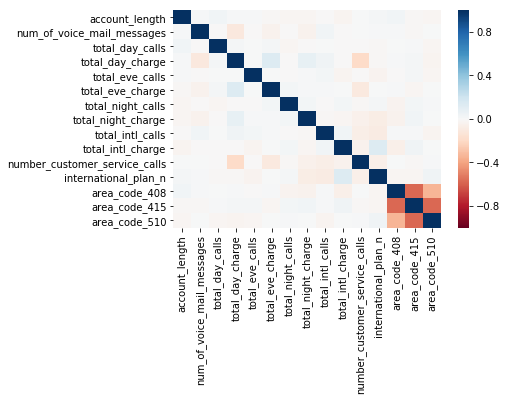

In [73]:
#check to see if sampling has affected colinearity.
sns.heatmap(X_samp.corr(),vmin=-1,vmax=1,center=0,cmap='RdBu')

### 1. Logisitic Regression Modelling

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


# create training and testing vars, check shape
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2,random_state=123)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(6867, 15) (6867,)
(1717, 15) (1717,)


In [75]:
# Make an instance of a LinearRegression object.
lr = LogisticRegression()
type(lr)

sklearn.linear_model.logistic.LogisticRegression

In [76]:
#fit model, print coefficients
model = lr.fit(X_train, y_train)
print(lr.intercept_)
print(lr.coef_)

[-0.68334051]
[[ 0.06034927 -0.46044573  0.04311776  0.77387899 -0.01223031  0.43202967
  -0.06308781  0.25381826 -0.1568363   0.23789095  0.87602113  0.71344466
   0.02847505 -0.03032511  0.00648021]]


In [77]:
print(feature_names[3],',',feature_names[10],',',feature_names[11])

total_day_charge , number_customer_service_calls , international_plan_n


From an initial viewing, the above metrics have higher coefficients associated with them. 

In [78]:
#assign array with predicted 'y' results to 'y_predicted'
y_pred = model.predict(X_test)
y_pred

array([0, 1, 1, ..., 1, 0, 1])

In [79]:
from sklearn import metrics

# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.8555217146998706

In [80]:
y_pred_train = model.predict(X_train)
print('Logistic Regression Testing Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Logistic Regression Accuracy:',metrics.accuracy_score(y_train, y_pred_train))
print('---Confusion Matrix---')
print(metrics.confusion_matrix(y_true=y_test, y_pred=preds > .5))

Logistic Regression Testing Accuracy: 0.7815958066394875
Logistic Regression Accuracy: 0.7849133537206932
---Confusion Matrix---
[[660 183]
 [192 682]]


> Scores are close, indicating model is not overfitted.

### 2. Elastic Net Regularisation

In [81]:
#define a range of alphas for optimising enet
alpha_range = 10.**np.arange(-2, 3)
alpha_range

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [82]:
from sklearn.linear_model import SGDClassifier

opt_auc = 0
#find optimal auc through optimal alpha, use coefficients for feature selection
for n in alpha_range:
    clf = SGDClassifier(penalty='elasticnet',alpha=n,max_iter=1000, loss = 'log',random_state=123)
    clf_model = clf.fit(X_train, y_train)
    predicted_enet = clf.predict_proba(X_test)
    preds = predicted_enet[:,1]
    fpr_enet, tpr_enet, threshold_enet = metrics.roc_curve(y_test, preds)
    roc_auc_enet = metrics.auc(fpr_enet, tpr_enet)
    #determine the optimum alpha by storing 'n' and its 
    #associated metrics if AUC is larger than AUC for previous n.
    if roc_auc_enet >= opt_auc:
        opt_preds = preds
        opt_auc = roc_auc_enet
        opt_int = clf.intercept_
        opt_coef = clf.coef_
        opt_alpha = n
print('AUC for optimal alpha: ', opt_auc)    
print('Optimal alpha: ', opt_alpha)    
print('Intercept: ', opt_int)
print('coefficients: ',opt_coef)

AUC for optimal alpha:  0.8556031499140859
Optimal alpha:  0.01
Intercept:  [-0.61357972]
coefficients:  [[ 0.04362697 -0.40886348  0.03083594  0.69823179  0.          0.38294732
  -0.0473364   0.22019008 -0.13755107  0.20488582  0.78566804  0.65239969
   0.01523696 -0.02900043  0.        ]]


#### Elastic net feature removal
> elastic net regularisation deprecated the following features:

> __1. 'total_eve_calls'__

> __2. 'area_code_510'__

> We will now use the optimal alpha value of 0.01 to re-fit our model and observe AUC.

In [83]:
clf_2 = SGDClassifier(penalty='elasticnet',alpha=0.01,max_iter=1000, loss = 'log',random_state=123)
clf_model_2 = clf_2.fit(X_train, y_train)
predicted_enet_2 = clf_2.predict_proba(X_test)
print(clf_model_2.intercept_)
print(clf_model_2.coef_)

[-0.61357972]
[[ 0.04362697 -0.40886348  0.03083594  0.69823179  0.          0.38294732
  -0.0473364   0.22019008 -0.13755107  0.20488582  0.78566804  0.65239969
   0.01523696 -0.02900043  0.        ]]


In [84]:
preds = predicted_enet_2[:,1]
fpr_enet_2, tpr_enet_2, threshold_enet_2 = metrics.roc_curve(y_test, preds)
roc_auc_enet_2 = metrics.auc(fpr_enet_2, tpr_enet_2)
roc_auc_enet_2

0.8556031499140859

In [85]:
y_pred = clf_model_2.predict(X_test)
y_pred_train = clf_model_2.predict(X_train)
print('ElasticNet Testing Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('ElasticNet Training Accuracy:',metrics.accuracy_score(y_train, y_pred_train))
print('---Confusion Matrix---')
print(metrics.confusion_matrix(y_true=y_test, y_pred=preds > .5))

ElasticNet Testing Accuracy: 0.7839254513686663
ElasticNet Training Accuracy: 0.7856414737148683
---Confusion Matrix---
[[660 183]
 [188 686]]


### 3. LogReg re-fit (removing features reduced from ENET)

In [86]:
#re-fit model, removing features highlighted from elasticnet


enet_predictors = ['account_length','num_of_voice_mail_messages','total_day_calls','total_day_charge',
                 'total_eve_charge','total_night_calls','total_night_charge',
                 'total_intl_calls','total_intl_charge','number_customer_service_calls','international_plan_n',
                 'area_code_408','area_code_415']
#assign enet predictors to balanced X data
X_samp_f = X_samp[enet_predictors]

#split data
X_train, X_test, y_train, y_test = train_test_split(X_samp_f, y_res, test_size=0.2,random_state=123)


lr = LogisticRegression()
model_2 = lr.fit(X_train, y_train)

#calculate AUC of new model
probs = model_2.predict_proba(X_test)
preds = probs[:,1]
fpr_2, tpr_2, threshold_2 = metrics.roc_curve(y_test, preds)
roc_auc_2 = metrics.auc(fpr_2, tpr_2)
roc_auc_2

0.855561075053408

In [87]:
y_pred = model_2.predict(X_test)
y_pred_train = model_2.predict(X_train)
print('2nd LogReg Testing Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('2nd LogReg Training Accuracy:',metrics.accuracy_score(y_train, y_pred_train))
print('---Confusion Matrix---')
print(metrics.confusion_matrix(y_true=y_test, y_pred=preds > .5))

2nd LogReg Testing Accuracy: 0.7833430401863716
2nd LogReg Training Accuracy: 0.7846221057230232
---Confusion Matrix---
[[662 181]
 [191 683]]


### 4. K-fold cross validation on original LogReg model

no_folds    4.000000
scores      0.785531
Name: 2, dtype: float64


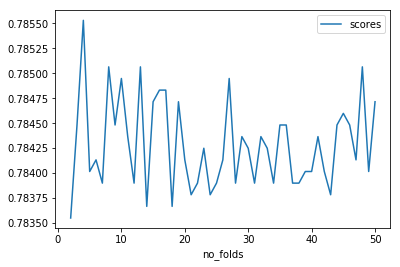

In [88]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

score_list = []
no_folds = []
for n in range(2,51):
    predicted = cross_val_predict(model, X_samp_f, y_res, cv=n)
    score = metrics.accuracy_score(y_res, predicted)
    no_folds.append(n)
    score_list.append(score)

s = {'no_folds':no_folds, 'scores':score_list}
n_scores = pd.DataFrame(s)
print(n_scores.iloc[n_scores['scores'].values.argmax()])
n_scores.plot('no_folds', 'scores')

#### Optimal number of folds is 4. We will use this for final cross-validation.

### 5. KNN Classification 

knn_acc           0.950495
num_neighbours    2.000000
Name: 0, dtype: float64


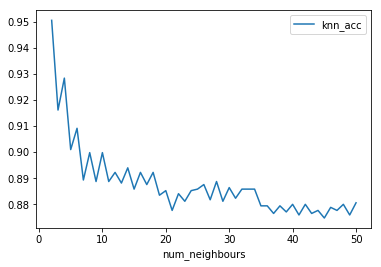

In [89]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
#looped function for calculating accuracy for various neighbours
knn_acc = []
num_neighbours = []

for n in range(2,51):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn_model = knn.fit(X_train, y_train)
    predicted_knn = knn_model.predict(X_test)
    knn_acc.append(accuracy_score(y_test, predicted_knn))
    num_neighbours.append(n)
    
s = {'knn_acc':knn_acc, 'num_neighbours':num_neighbours}
knn_scores = pd.DataFrame(s)
print(knn_scores.iloc[knn_scores['knn_acc'].values.argmax()])
knn_scores.plot('num_neighbours', 'knn_acc')

#### Optimal number of neigbours is 2. We will use n = 2 for computing ROC & AUC.

In [90]:
knn_13 = KNeighborsClassifier(n_neighbors=2)
knn_model = knn.fit(X_train, y_train)
predicted_knn = knn.predict_proba(X_test)
preds = predicted_knn[:,1]
fpr_knn, tpr_knn, threshold_knn = metrics.roc_curve(y_test, preds)
roc_auc_knn = metrics.auc(fpr_knn, tpr_knn)
roc_auc_knn

0.9429878851546319

In [91]:
y_pred = knn_model.predict(X_test)
y_pred_train = knn_model.predict(X_train)
print('KNN Testing Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('KNN Training Accuracy:',metrics.accuracy_score(y_train, y_pred_train))
print('---Confusion Matrix---')
print(metrics.confusion_matrix(y_true=y_test, y_pred=preds > .5))

KNN Testing Accuracy: 0.8806057076295865
KNN Training Accuracy: 0.8572884811416922
---Confusion Matrix---
[[708 135]
 [ 70 804]]


### 6. Decision Tree Model

In [92]:
from sklearn import tree
clf_tree = tree.DecisionTreeClassifier()
dtree_model = clf_tree.fit(X_train, y_train)
predicted_tree = clf_tree.predict_proba(X_test)
preds = predicted_tree[:,1]
fpr_tree, tpr_tree, threshold_tree = metrics.roc_curve(y_test, preds)
roc_auc_tree = metrics.auc(fpr_tree, tpr_tree)
roc_auc_tree

0.9295578610769535

In [93]:
import graphviz 
dot_data = tree.export_graphviz(dtree_model, out_file=None) 
graph = graphviz.Source(dot_data) 
#graph.render("Telco Churn") 

In [94]:
y_pred = dtree_model.predict(X_test)
y_pred_train = dtree_model.predict(X_train)
print('Decision Tree Testing Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Decision Tree Training Accuracy:',metrics.accuracy_score(y_train, y_pred_train))
print('---Confusion Matrix---')
print(metrics.confusion_matrix(y_true=y_test, y_pred=preds > .5))

Decision Tree Testing Accuracy: 0.9295282469423413
Decision Tree Training Accuracy: 1.0
---Confusion Matrix---
[[785  58]
 [ 63 811]]


### 7-a. Random Forest Model

In [95]:
#split data according to original dataset

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2,random_state=123)

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
rf_clf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf_model = rf_clf.fit(X_train,y_train)

rf_pred_prob = rf_model.predict_proba(X_test)
preds = rf_pred_prob[:,1]
fpr_rf, tpr_rf, threshold_rf = metrics.roc_curve(y_test, preds)
roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)
roc_auc_rf

0.9942276005657033

In [96]:
rf_y_pred = rf_clf.predict(X_test)
rf_pred_train = rf_clf.predict(X_train)
print('RandForest Testing Accuracy:', metrics.accuracy_score(y_test, rf_y_pred))
print('RandForest Training Accuracy:',metrics.accuracy_score(y_train, rf_pred_train))
print('---Confusion Matrix---')
print(metrics.confusion_matrix(y_true=y_test, y_pred=preds > .5))

RandForest Testing Accuracy: 0.9644729178800233
RandForest Training Accuracy: 1.0
---Confusion Matrix---
[[826  17]
 [ 44 830]]


### 7-b. Feature Important from Random Forest

In [97]:
feature_imp = pd.Series(rf_model.feature_importances_,index=feature_names).sort_values(ascending=False)
feature_imp

total_day_charge                 0.221280
number_customer_service_calls    0.179303
international_plan_n             0.100914
total_intl_calls                 0.082273
total_eve_charge                 0.080682
total_intl_charge                0.057444
total_night_charge               0.055351
num_of_voice_mail_messages       0.045405
total_eve_calls                  0.040347
account_length                   0.040230
total_night_calls                0.039674
total_day_calls                  0.038882
area_code_415                    0.006833
area_code_408                    0.005864
area_code_510                    0.005517
dtype: float64

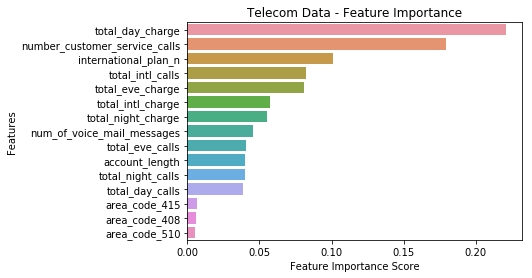

In [98]:
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Telecom Data - Feature Importance")
plt.show()

### 8. Final LogReg Model, removing features below 2% important

In [99]:
#re-fit model, removing features highlighted from elasticnet


rf_predictors = ['account_length','num_of_voice_mail_messages','total_day_calls','total_day_charge',
                 'total_eve_charge','total_night_calls','total_night_charge',
                 'total_intl_calls','total_intl_charge','number_customer_service_calls','international_plan_n']
#assign RandomForest predictors to balanced X data
X_samp_randf = X_samp[rf_predictors]

#split data
X_train, X_test, y_train, y_test = train_test_split(X_samp_randf, y_res, test_size=0.2,random_state=123)


lr_3 = LogisticRegression()
model_3 = lr_3.fit(X_train, y_train)

#calculate AUC of new model
probs = model_3.predict_proba(X_test)
preds = probs[:,1]
fpr_3, tpr_3, threshold_3 = metrics.roc_curve(y_test, preds)
roc_auc_3 = metrics.auc(fpr_3, tpr_3)
roc_auc_3

0.8559261762638066

In [100]:
y_pred = model_3.predict(X_test)
y_pred_train = model_3.predict(X_train)
print('RandForest Testing Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('RandForest Training Accuracy:',metrics.accuracy_score(y_train, y_pred_train))
print('---Confusion Matrix---')
print(metrics.confusion_matrix(y_true=y_test, y_pred=preds > .5))

RandForest Testing Accuracy: 0.7897495631916133
RandForest Training Accuracy: 0.7830202417358381
---Confusion Matrix---
[[665 178]
 [183 691]]


### 9. Cross-validate All models

In [101]:
#cross-validate all models with optimal number of folds - 4 folds.
cv_knn = cross_val_score(knn_model, X_res, y_res, cv=4, scoring='roc_auc').mean()
cv_lr = cross_val_score(model, X_res, y_res, cv=4, scoring='roc_auc').mean()
cv_lr_2nd = cross_val_score(model_2, X_samp_f, y_res, cv=4, scoring='roc_auc').mean()
cv_enet = cross_val_score(clf_model_2, X_res, y_res, cv=4, scoring='roc_auc').mean()
cv_dtree = cross_val_score(dtree_model, X_samp_f, y_res, cv=4, scoring='roc_auc').mean()
cv_rf = cross_val_score(rf_model, X_samp_f, y_res, cv=4, scoring='roc_auc').mean()
cv_lr_3rd = cross_val_score(model_3, X_samp_randf, y_res, cv=4, scoring='roc_auc').mean()

print('Cross-validated AUC for KNN model is', cv_knn)
print('Cross-validated AUC for 1st LogReg model is', cv_lr)
print('Cross-validated AUC for Refitted LogReg model is', cv_lr_2nd) 
print('Cross-validated AUC for 2nd ElasticNet model is', cv_enet)
print('Cross-validated AUC for Decision Tree model is', cv_dtree)
print('Cross-validated AUC for Random Forest model is', cv_rf)
print('Cross-validated AUC for Final LogReg is', cv_lr_3rd)

Cross-validated AUC for KNN model is 0.9256208477333586
Cross-validated AUC for 1st LogReg model is 0.8415368239660427
Cross-validated AUC for Refitted LogReg model is 0.841789792491981
Cross-validated AUC for 2nd ElasticNet model is 0.8417226961190067
Cross-validated AUC for Decision Tree model is 0.9126281453867661
Cross-validated AUC for Random Forest model is 0.992933166801149
Cross-validated AUC for Final LogReg is 0.8418178035991449


### 10. Plot ROC and AUC for all models

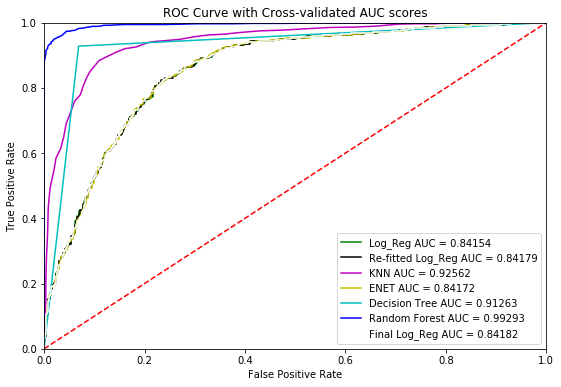

In [102]:
#Plot AUC for all models
fig, ax = plt.subplots(figsize=(9, 6))
plt.title('ROC Curve with Cross-validated AUC scores')
plt.plot(fpr, tpr, 'g', label = 'Log_Reg AUC = %0.5f' % cv_lr)
plt.plot(fpr_2, tpr_2, 'k', label = 'Re-fitted Log_Reg AUC = %0.5f' % cv_lr_2nd)
plt.plot(fpr_knn, tpr_knn, 'm', label = 'KNN AUC = %0.5f' % cv_knn)
plt.plot(fpr_enet_2, tpr_enet_2, 'y', label = 'ENET AUC = %0.5f' % cv_enet)
plt.plot(fpr_tree, tpr_tree, 'c', label = 'Decision Tree AUC = %0.5f' % cv_dtree)
plt.plot(fpr_rf, tpr_rf, 'b', label = 'Random Forest AUC = %0.5f' % cv_rf)
plt.plot(fpr_3, tpr_3, 'w', label = 'Final Log_Reg AUC = %0.5f' % cv_lr_3rd)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

> Observing AUC's of our models, KNN and Decision tree models have better discrimination ability.